In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import scipy
import math
from scipy import constants
import pandas as pd


In [2]:
# SHARED
_k_b = scipy.constants.k
_rho = 4200
_rho_f = 790

_r =  1.290153649828586e-06
_gain = np.sqrt(450696654238001.6)
_K = 6.746007702007992e-05

_m = 4/3 *np.pi *_r**3*_rho + 2/3 *np.pi *_r**3*_rho_f
_temp = 293
_viscous = 0.32e-3
_v_force = 6*np.pi*_r*_viscous

bin_number_data = 30
timestep_data = bin_number_data/200000000

print(timestep_data)
print("momentum relation time is " + str(_m/_v_force))


1.5e-07
momentum relation time is 5.311361904557549e-06


In [3]:
def compute_roots(m, K, r, eta, rho_f):
    t_f = (rho_f * r ** 2) / eta
    t_p = m / (6 * np.pi * r * eta)
    a = 1
    b = -6*math.pi*r**2*np.sqrt(rho_f*eta)/m
    c = 6*math.pi*r*eta/m
    d = 0
    e = K/m

    coeffs = [a, b, c, d, e]
    return np.roots(coeffs)

roots = compute_roots(_m, _K, _r, _viscous, _rho_f)

def a_inverse_form(t, roots):
    return np.real((1/_m) * sum(
        (z**3 * scipy.special.erfcx(z * np.sqrt(t))) /
        (np.prod([z - z_j for z_j in roots if z != z_j])) for z in roots))

def b_inverse_form(t, roots):
    return np.real((1/_m) * sum(
        (z * scipy.special.erfcx(z * np.sqrt(t))) /
        (np.prod([z - z_j for z_j in roots if z != z_j])) for z in roots))

def c_inverse_form(t, roots):
    a = roots[0]
    b = roots[1]
    c = roots[2]
    d = roots[3]

    m_over_k = 1/(a*b*c*d)

    ret = np.real((1/_m) * sum(
        (scipy.special.erfcx(z * np.sqrt(t))) /
        (z*(np.prod([z - z_j for z_j in roots if z != z_j]))) for z in roots))

    return ret + m_over_k/_m

def s_half_b_inverse_form(t, roots):
    return np.real((-1/_m) * sum(
        (z**2 * scipy.special.erfcx(z * np.sqrt(t))) /
        (np.prod([z - z_j for z_j in roots if z != z_j])) for z in roots))

def s_minus_half_b_inverse_form(t, roots):
     return np.real((-1/_m) * sum(
        (scipy.special.erfcx(z * np.sqrt(t))) /
        (np.prod([z - z_j for z_j in roots if z != z_j])) for z in roots))

def experfc_inverse_form(t, tau, roots):
    return np.real((1/_m) * sum(
        (z * ((1/np.sqrt(np.pi*(t-tau)))-(z*np.exp(z**2*(t-tau))*scipy.special.erfc(z*np.sqrt(t-tau))))) /
        (np.prod([z - z_j for z_j in roots if z != z_j])) for z in roots))

def ensemble_r_term(t1, t2, m, K, roots):
    return np.real((constants.k*_temp)*(c_inverse_form(t1, roots) + c_inverse_form(t2, roots) - c_inverse_form(np.abs(t2-t1), roots) - m*b_inverse_form(t1, roots)*b_inverse_form(t2, roots) - K*c_inverse_form(t1, roots)*c_inverse_form(t2, roots)))

def e_and_f(t, mass, radius, rho_f, eta, x0, v0, roots):
    gamma = 6*np.pi*radius*eta
    z = 6*radius**2*np.pi*np.sqrt(rho_f*eta)
    return mass*x0*a_inverse_form(t, roots) + mass*v0*b_inverse_form(t, roots) + gamma*x0*b_inverse_form(t, roots) + z*x0*s_half_b_inverse_form(t, roots) #+ z*v0*s_minus_half_b_inverse_form(t, roots)


def e_and_f_wrong(t, mass, radius, rho_f, eta, x0, v0, roots):
    gamma = 6*np.pi*radius*eta
    z = 6*radius**2*np.pi*np.sqrt(rho_f*eta)
    return mass*x0*a_inverse_form(t, roots) + mass*v0*b_inverse_form(t, roots) + gamma*x0*b_inverse_form(t, roots) + z*x0*s_half_b_inverse_form(t, roots) + z*v0*s_minus_half_b_inverse_form(t, roots)

def x_t1_x_t2(t1, t2, m, K, radius, eta, rho_f, x0, v0):
    return e_and_f(t1, m, radius, rho_f, eta, x0, v0, roots)*e_and_f(t2, m, radius, rho_f, eta, x0, v0, roots) + ensemble_r_term(t1,t2, m, K, roots)

def x_t1_x_t2_wrong(t1, t2, m, K, radius, eta, rho_f, x0, v0):
    return e_and_f_wrong(t1, m, radius, rho_f, eta, x0, v0, roots)*e_and_f_wrong(t2, m, radius, rho_f, eta, x0, v0, roots) + ensemble_r_term(t1,t2, m, K, roots)

def full_hydro_msd(t1, t2, m, K, radius, eta, rho_f, x0, v0):
    return x_t1_x_t2(t1, t1, m, K, radius, eta, rho_f, x0, v0) + x_t1_x_t2(t2, t2, m, K, radius, eta, rho_f, x0, v0) - 2 * x_t1_x_t2(t1, t2, m, K, radius, eta, rho_f, x0, v0)

def full_hydro_msd_wrong(t1, t2, m, K, radius, eta, rho_f, x0, v0):
    return x_t1_x_t2_wrong(t1, t1, m, K, radius, eta, rho_f, x0, v0) + x_t1_x_t2_wrong(t2, t2, m, K, radius, eta, rho_f, x0, v0) - 2 * x_t1_x_t2_wrong(t1, t2, m, K, radius, eta, rho_f, x0, v0)

In [9]:
speeds = np.array([0, .5, 1, 2])

In [10]:
times_analytic = np.logspace(-8, -2, 100)

mu = 0
# sigma_v = np.sqrt(_k_b*_temp/_m)
sigma_x = np.sqrt(_k_b*_temp/_K)

num_samples = 10000

# initial_conditions_v = np.random.normal(mu, sigma_v, num_samples)
initial_conditions_x = np.random.normal(mu, sigma_x, num_samples)

results_speed_no_half = np.zeros((num_samples, len(times_analytic)))
results_wrong = np.zeros((num_samples, len(times_analytic)))

speeds_analytic_no_half = []
speeds_analytic_wrong = []
for speed in speeds:
    print("Speed X")
    for i in range(num_samples):
        results_speed_no_half[i, :] = full_hydro_msd(0, times_analytic, _m, _K, _r, _viscous, _rho_f, initial_conditions_x[i], speed* np.sqrt(_k_b*_temp/_m))
        results_wrong[i, :] = full_hydro_msd_wrong(0, times_analytic, _m, _K, _r, _viscous, _rho_f, initial_conditions_x[i], speed* np.sqrt(_k_b*_temp/_m))
    speeds_analytic_no_half.append(results_speed_no_half.mean(axis=0))
    results_speed_no_half = np.zeros((num_samples, len(times_analytic)))
    speeds_analytic_wrong.append(results_wrong.mean(axis=0))
    results_wrong = np.zeros((num_samples, len(times_analytic)))

Speed X
Speed X
Speed X
Speed X


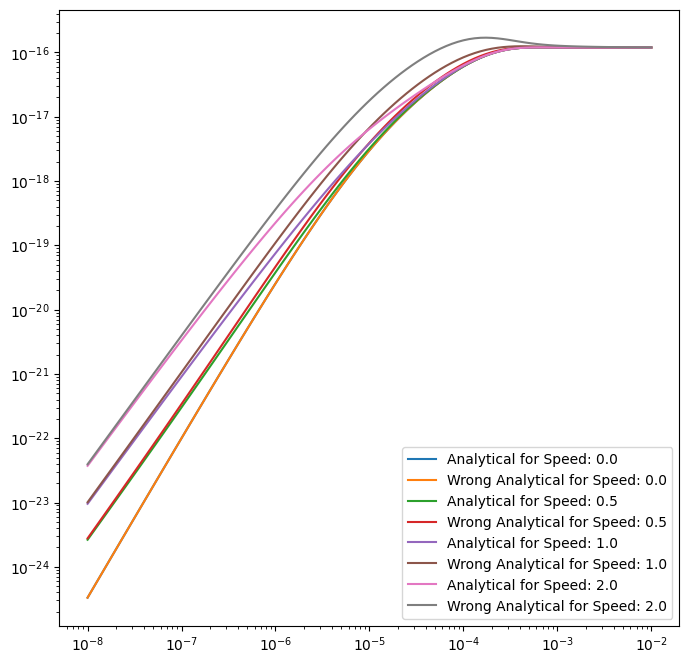

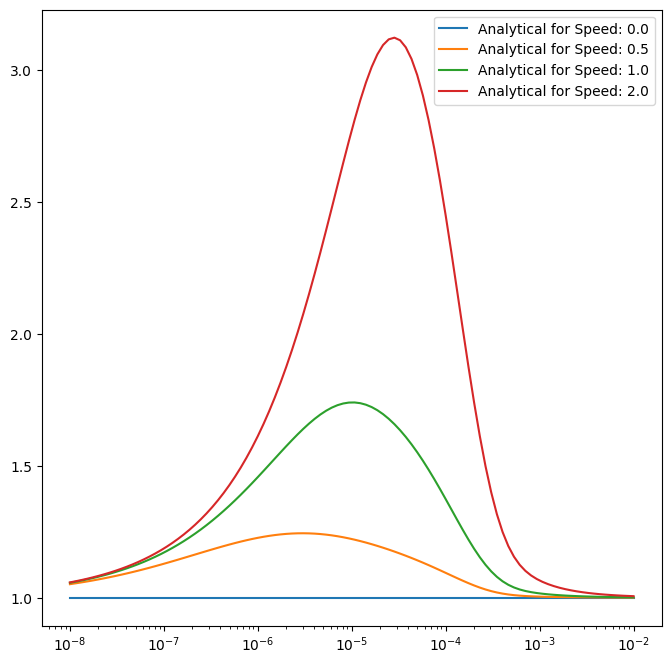

In [13]:
plt.figure(figsize=(8,8))
for i in range(0, len(speeds)):
    plt.plot(times_analytic, speeds_analytic_no_half[i], label=f"Analytical for Speed: {speeds[i]}")
    plt.plot(times_analytic, speeds_analytic_wrong[i], label=f"Wrong Analytical for Speed: {speeds[i]}")

plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

plt.figure(figsize=(8,8))
for i in range(0, len(speeds)):
    plt.plot(times_analytic, speeds_analytic_wrong[i]/speeds_analytic_no_half[i], label=f"Analytical for Speed: {speeds[i]}")

plt.xscale('log')
plt.legend()
plt.show()